In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("./US_Accidents_50k.csv")
print(df.shape)
df.head()

(50000, 46)


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-3135565,Source2,3,2017-12-18 20:39:26,2017-12-18 21:24:05,26.231586,-80.136581,NaN,NaN,0.000,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-3933005,Source1,2,2022-01-12 08:33:00,2022-01-12 10:46:35,28.541458,-81.475852,28.539172,-81.475874,0.158,...,False,False,False,False,False,False,Day,Day,Day,Day
2,A-1263310,Source2,2,2020-11-17 10:36:29,2020-11-17 11:06:05,29.851583,-95.504662,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-7511056,Source1,2,2018-11-29 17:28:45,2018-11-29 21:28:44,42.148838,-121.698240,42.143724,-121.698269,0.353,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-7743457,Source1,2,2019-06-26 06:35:00,2019-06-26 07:45:00,40.914630,-111.891470,40.908653,-111.891500,0.413,...,False,False,False,False,False,False,Day,Day,Day,Day


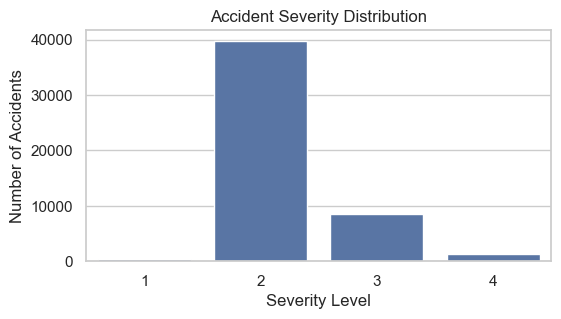

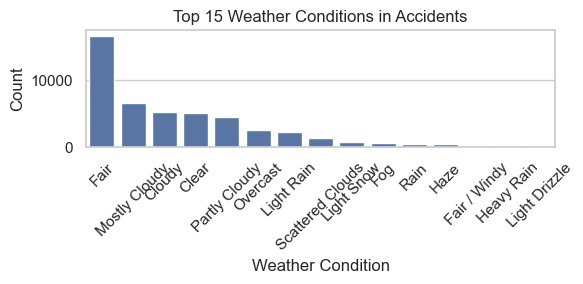

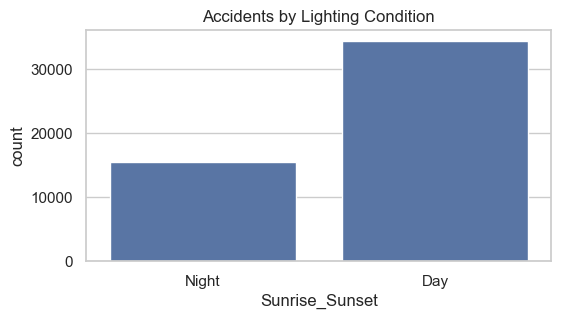

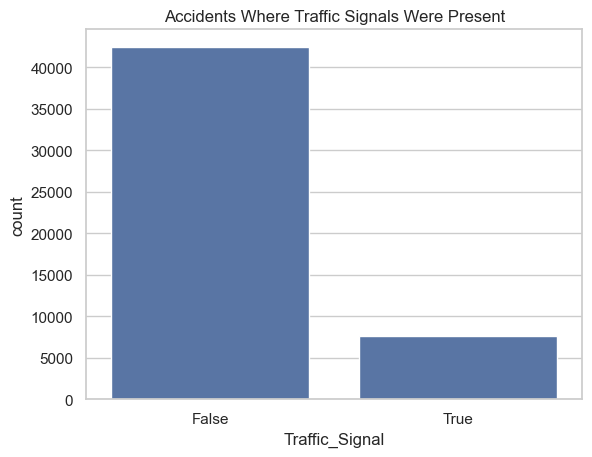

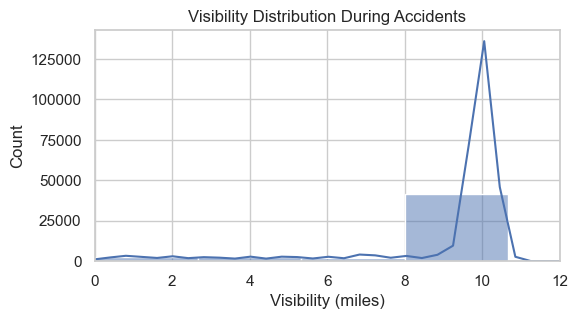

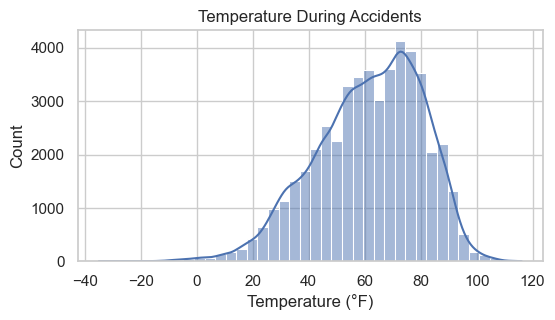

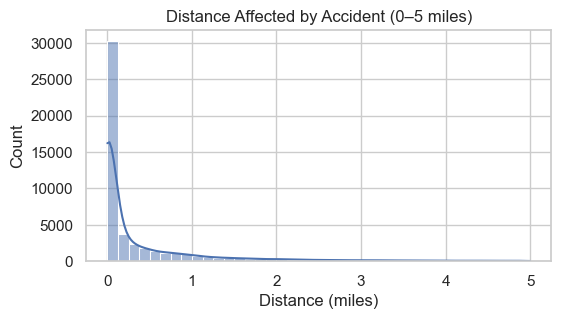

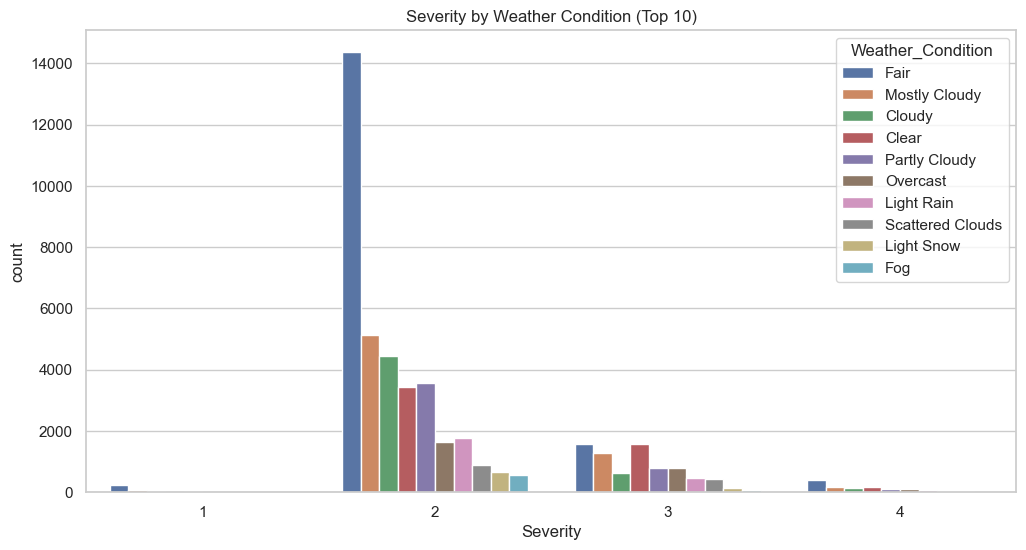

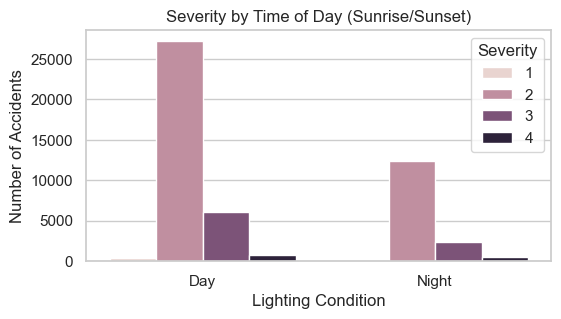

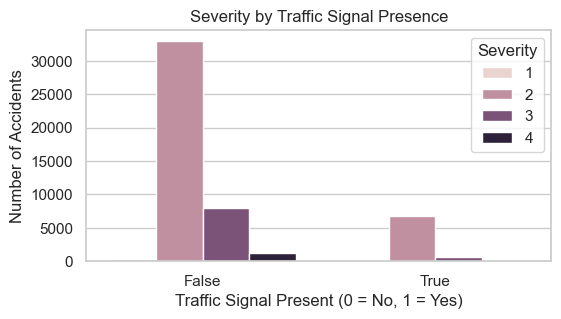

In [69]:
#Visualize the data -- Univariate
plt.figure(figsize=(6,3))
sns.countplot(x='Severity', data=df)
plt.title("Accident Severity Distribution")
plt.xlabel("Severity Level")
plt.ylabel("Number of Accidents")
plt.show()

plt.figure(figsize=(6,3))
top_weather = df['Weather_Condition'].value_counts().nlargest(15)
sns.barplot(x=top_weather.index, y=top_weather.values)
plt.title("Top 15 Weather Conditions in Accidents")
plt.xlabel("Weather Condition")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
sns.countplot(x='Sunrise_Sunset', data=df)
plt.title("Accidents by Lighting Condition")
plt.show()

sns.countplot(x='Traffic_Signal', data=df)
plt.title("Accidents Where Traffic Signals Were Present")
plt.show()

plt.figure(figsize=(6,3))
sns.histplot(df['Visibility(mi)'], bins=30, kde=True)
plt.title("Visibility Distribution During Accidents")
plt.xlim(0,12)
plt.xlabel("Visibility (miles)")
plt.show()

plt.figure(figsize=(6,3))
sns.histplot(df['Temperature(F)'], bins=40, kde=True)
plt.title("Temperature During Accidents")
plt.xlabel("Temperature (°F)")
plt.show()

plt.figure(figsize=(6, 3))
filtered_df = df[df['Distance(mi)'] <= 5]
sns.histplot(filtered_df['Distance(mi)'], bins=40, kde=True)
plt.title("Distance Affected by Accident (0–5 miles)")
plt.xlabel("Distance (miles)")
plt.ylabel("Count")
plt.show()


#Visualize the data -- Multivariate
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Severity', hue='Weather_Condition',
              order=[1,2,3,4], hue_order=df['Weather_Condition'].value_counts().index[:10])
plt.title("Severity by Weather Condition (Top 10)")
plt.show()

plt.figure(figsize=(6,3))
sns.countplot(data=df, x='Sunrise_Sunset', hue='Severity', order=['Day', 'Night'], hue_order=[1,2,3,4])
plt.title("Severity by Time of Day (Sunrise/Sunset)")
plt.xlabel("Lighting Condition")
plt.ylabel("Number of Accidents")
plt.legend(title='Severity')
plt.show()

plt.figure(figsize=(6,3))
sns.countplot(data=df, x='Traffic_Signal', hue='Severity', hue_order=[1,2,3,4])
plt.title("Severity by Traffic Signal Presence")
plt.xlabel("Traffic Signal Present (0 = No, 1 = Yes)")
plt.ylabel("Number of Accidents")
plt.legend(title='Severity')
plt.show()


In [70]:
#Preprocessing and some feature engineering

df_clean = df.copy()
print(f"Shape before preprocessing: {df_clean.shape}")

# Ensure 'Start_Time' and 'End_Time' are parsed correctly
df_clean['Start_Time'] = pd.to_datetime(df_clean['Start_Time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
df_clean['End_Time'] = pd.to_datetime(df_clean['End_Time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# Drop rows where timestamp conversion failed
rows_before_drop = df_clean.shape[0]
df_clean = df_clean.dropna(subset=['Start_Time', 'End_Time'])
print(f"\nDropped {rows_before_drop - df_clean.shape[0]} rows due to invalid timestamps.")
print(f"Shape after dropping invalid datetimes: {df_clean.shape}")

# Create time-based features
df_clean['Hour'] = df_clean['Start_Time'].dt.hour
df_clean['DayOfWeek'] = df_clean['Start_Time'].dt.dayofweek #Monday-> 0 and Sunday->6
df_clean['Month'] = df_clean['Start_Time'].dt.month
df_clean['Year'] = df_clean['Start_Time'].dt.year
df_clean['Is_Weekend'] = df_clean['DayOfWeek'].isin([5, 6]).astype(int)

# Calculate Duration
df_clean['Duration(mins)'] = (df_clean['End_Time'] - df_clean['Start_Time']).dt.total_seconds() / 60

# handling potential negative durations
neg_duration_count = (df_clean['Duration(mins)'] < 0).sum()
if neg_duration_count > 0:
    print(f"Warning: Found {neg_duration_count} entries with negative duration. Setting them to 0.")
    df_clean.loc[df_clean['Duration(mins)'] < 0, 'Duration(mins)'] = 0

print("\nCreated time-based features: Hour, DayOfWeek, Month, Year, Is_Weekend, Duration(mins).")

# handling missing numerical values
num_cols_to_impute = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
                      'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
print("\nImputing missing values in numerical columns using median:")
for col in num_cols_to_impute:
    median_val = df_clean[col].median()
    missing_count = df_clean[col].isna().sum()
    if missing_count > 0:
        df_clean[col] = df_clean[col].fillna(median_val)
        print(f" - Filled {missing_count} missing values in '{col}' with median ({median_val:.2f})")

# encode sunset/sunrise
df_clean['Is_Night'] = df_clean['Sunrise_Sunset'].apply(lambda x: 1 if x == 'Night' else 0)
print("\nEncoded 'Sunrise_Sunset' into binary 'Is_Night' (1 for Night, 0 for Day).")

# missing severity drop
rows_before_drop = df_clean.shape[0]
df_clean = df_clean.dropna(subset=['Severity'])
print(f"\nDropped {rows_before_drop - df_clean.shape[0]} rows with missing Severity.")

# remove excessively long duration accidents
max_duration_threshold = 1440
rows_before_drop = df_clean.shape[0]
df_clean = df_clean[df_clean['Duration(mins)'] <= max_duration_threshold]
print(f"Removed {rows_before_drop - df_clean.shape[0]} rows with Duration(mins) > {max_duration_threshold}.")
print(f"Shape after initial cleaning and feature engineering: {df_clean.shape}")

# simplify and encode weather
def map_weather_condition(condition):
    condition = str(condition).lower()
    if "fair" in condition or "clear" in condition:
        return "Clear"
    elif "cloud" in condition or "overcast" in condition or "scattered" in condition:
        return "Cloudy"
    elif "rain" in condition or "drizzle" in condition or "shower" in condition:
        return "Rain"
    elif "snow" in condition or "wintry" in condition or "ice" in condition:
        return "Snow"
    elif "fog" in condition or "haze" in condition or "mist" in condition or "smoke" in condition:
        return "Fog"
    elif "thunder" in condition or "t-storm" in condition:
        return "Thunderstorm"
    elif "windy" in condition or "squalls" in condition:
        return "Windy"
    else:
        return "Other"

df_clean['Weather_Simplified'] = df_clean['Weather_Condition'].apply(map_weather_condition)
print("\nMapped 'Weather_Condition' into simplified categories ('Weather_Simplified').")

# One-hot encode simplified weather categories to int
weather_dummies = pd.get_dummies(df_clean['Weather_Simplified'], prefix='Weather', dummy_na=False, dtype=int) # int conversion 0 / 1
df_clean = pd.concat([df_clean, weather_dummies], axis=1)
print(f"\nOne-hot encoded simplified weather (0/1). New cols: {list(weather_dummies.columns)}")

# low visibility flag for dangerously low visibility
low_vis_threshold = 3
df_clean['Low_Visibility_Flag'] = (df_clean['Visibility(mi)'] < low_vis_threshold).astype(int) # bool conversion 0 / 1
print(f"\nAdded 'Low_Visibility_Flag' (1 if Visibility(mi) < {low_vis_threshold}, else 0). "
      f"Count: {df_clean['Low_Visibility_Flag'].sum()}")


print(f"\nShape after Cell 3 processing: {df_clean.shape}")
print("\nColumns after Cell 3 processing:")
print(df_clean.columns.tolist())
print("\nSample of engineered features (first 5 rows):")
print(df_clean[['Start_Time', 'Hour', 'DayOfWeek', 'Is_Weekend', 'Duration(mins)', 'Is_Night', 'Weather_Simplified', 'Low_Visibility_Flag'] + list(weather_dummies.columns)].head())

Shape before preprocessing: (50000, 46)

Dropped 4778 rows due to invalid timestamps.
Shape after dropping invalid datetimes: (45222, 46)

Created time-based features: Hour, DayOfWeek, Month, Year, Is_Weekend, Duration(mins).

Imputing missing values in numerical columns using median:
 - Filled 910 missing values in 'Temperature(F)' with median (64.00)
 - Filled 12939 missing values in 'Wind_Chill(F)' with median (61.00)
 - Filled 972 missing values in 'Humidity(%)' with median (67.00)
 - Filled 778 missing values in 'Pressure(in)' with median (29.87)
 - Filled 999 missing values in 'Visibility(mi)' with median (10.00)
 - Filled 3528 missing values in 'Wind_Speed(mph)' with median (7.00)
 - Filled 14198 missing values in 'Precipitation(in)' with median (0.00)

Encoded 'Sunrise_Sunset' into binary 'Is_Night' (1 for Night, 0 for Day).

Dropped 0 rows with missing Severity.
Removed 189 rows with Duration(mins) > 1440.
Shape after initial cleaning and feature engineering: (45033, 53)

Mapp

In [71]:
# feature engineering

# convert bool cols to 0 / 1
bool_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
             'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
             'Traffic_Signal', 'Turning_Loop']

print("\nConverting boolean columns to 0/1 integers:")
for col in bool_cols:
    if col in df_clean.columns:
        if df_clean[col].dtype == 'bool' or df_clean[col].dtype == 'object':
             df_clean[col] = df_clean[col].astype(int)
             print(f" - Converted '{col}' to integer.")
        #handling missing vals
        if df_clean[col].isna().any():
             mode_val = df_clean[col].mode()[0]
             missing_count = df_clean[col].isna().sum()
             df_clean[col] = df_clean[col].fillna(mode_val)
             print(f"   - Filled {missing_count} missing values in '{col}' with mode ({mode_val})")
    else:
        print(f" - Warning: Boolean column '{col}' not found.")

# handling wind direction
print("\nHandling 'Wind_Direction':")
if 'Wind_Direction' in df_clean.columns:
    # standardization
    wind_map = {
        'Calm': 'CALM', 'Variable': 'VAR',
        'East': 'E', 'North': 'N', 'South': 'S', 'West': 'W'
    }
    df_clean['Wind_Direction'] = df_clean['Wind_Direction'].replace(wind_map).str.upper()
    print(f" - Standardized 'Wind_Direction' values. Unique values now: {df_clean['Wind_Direction'].unique()}")
    # filling missing vals
    mode_wind = df_clean['Wind_Direction'].mode()[0]
    missing_count = df_clean['Wind_Direction'].isna().sum()
    if missing_count > 0:
        df_clean['Wind_Direction'] = df_clean['Wind_Direction'].fillna(mode_wind)
        print(f" - Filled {missing_count} missing 'Wind_Direction' with standardized mode ('{mode_wind}')")
    # encoding standardized wind directions
    wind_dummies = pd.get_dummies(df_clean['Wind_Direction'], prefix='WindDir', dummy_na=False)
    df_clean = pd.concat([df_clean, wind_dummies], axis=1)
    print(f" - One-hot encoded standardized 'Wind_Direction'. New columns: {list(wind_dummies.columns)}")
else:
    print(" - 'Wind_Direction' column not found.")

# high cardinality columns being dropped
high_card_cols = ['Street', 'City', 'County', 'Zipcode', 'Airport_Code']
text_cols = ['Description']
cols_to_drop_high_card = [col for col in high_card_cols if col in df_clean.columns]
cols_to_drop_text = [col for col in text_cols if col in df_clean.columns]

print(f"\nDropping high cardinality location columns: {cols_to_drop_high_card}")
df_clean = df_clean.drop(columns=cols_to_drop_high_card, errors='ignore')

print(f"Dropping text description column: {cols_to_drop_text}")
df_clean = df_clean.drop(columns=cols_to_drop_text, errors='ignore')


# keeping start lattitude / longitude, dropping end since they are redundant w/ distance
print("\nHandling Geospatial columns: Keeping Start_Lat/Start_Lng, dropping End_Lat/End_Lng.")
if 'End_Lat' in df_clean.columns:
    df_clean = df_clean.drop(columns=['End_Lat'], errors='ignore')
if 'End_Lng' in df_clean.columns:
    df_clean = df_clean.drop(columns=['End_Lng'], errors='ignore')

# checking missing vals for start lattitude and longitude, filling w/ median
geo_cols_to_check = ['Start_Lat', 'Start_Lng']
print("Checking for missing values in Start_Lat/Start_Lng:")
for col in geo_cols_to_check:
    if col in df_clean.columns:
         missing_count = df_clean[col].isna().sum()
         if missing_count > 0:
             median_val = df_clean[col].median()
             df_clean[col] = df_clean[col].fillna(median_val)
             print(f" - Filled {missing_count} missing values in '{col}' with median ({median_val:.4f})")
    else:
         print(f" - Column '{col}' not found.")


print(f"\nShape after Cell 4 processing: {df_clean.shape}")
print("\nColumns after Cell 4 processing:")
print(df_clean.columns.tolist())


Converting boolean columns to 0/1 integers:
 - Converted 'Amenity' to integer.
 - Converted 'Bump' to integer.
 - Converted 'Crossing' to integer.
 - Converted 'Give_Way' to integer.
 - Converted 'Junction' to integer.
 - Converted 'No_Exit' to integer.
 - Converted 'Railway' to integer.
 - Converted 'Roundabout' to integer.
 - Converted 'Station' to integer.
 - Converted 'Stop' to integer.
 - Converted 'Traffic_Calming' to integer.
 - Converted 'Traffic_Signal' to integer.
 - Converted 'Turning_Loop' to integer.

Handling 'Wind_Direction':
 - Standardized 'Wind_Direction' values. Unique values now: ['ESE' 'NE' 'ENE' 'CALM' 'SW' 'S' 'N' 'VAR' 'E' 'NNE' 'W' nan 'WNW' 'SSW'
 'WSW' 'NW' 'NNW' 'SSE' 'SE']
 - Filled 946 missing 'Wind_Direction' with standardized mode ('CALM')
 - One-hot encoded standardized 'Wind_Direction'. New columns: ['WindDir_CALM', 'WindDir_E', 'WindDir_ENE', 'WindDir_ESE', 'WindDir_N', 'WindDir_NE', 'WindDir_NNE', 'WindDir_NNW', 'WindDir_NW', 'WindDir_S', 'WindDir_S


Columns identified for dropping: ['ID', 'Start_Time', 'End_Time', 'Weather_Timestamp', 'Sunrise_Sunset', 'Weather_Condition', 'Weather_Simplified', 'Wind_Direction', 'State', 'Timezone', 'Source', 'Country', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Wind_Chill(F)']

Shape after dropping columns: (45033, 57)

Remaining columns (features + target):
['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Hour', 'DayOfWeek', 'Month', 'Year', 'Is_Weekend', 'Duration(mins)', 'Is_Night', 'Weather_Clear', 'Weather_Cloudy', 'Weather_Fog', 'Weather_Other', 'Weather_Rain', 'Weather_Snow', 'Weather_Thunderstorm', 'Weather_Windy', 'Low_Visibility_Flag', 'WindDir_CALM', 'WindDir_E', 'WindDir_ENE', 'WindDir_ESE'

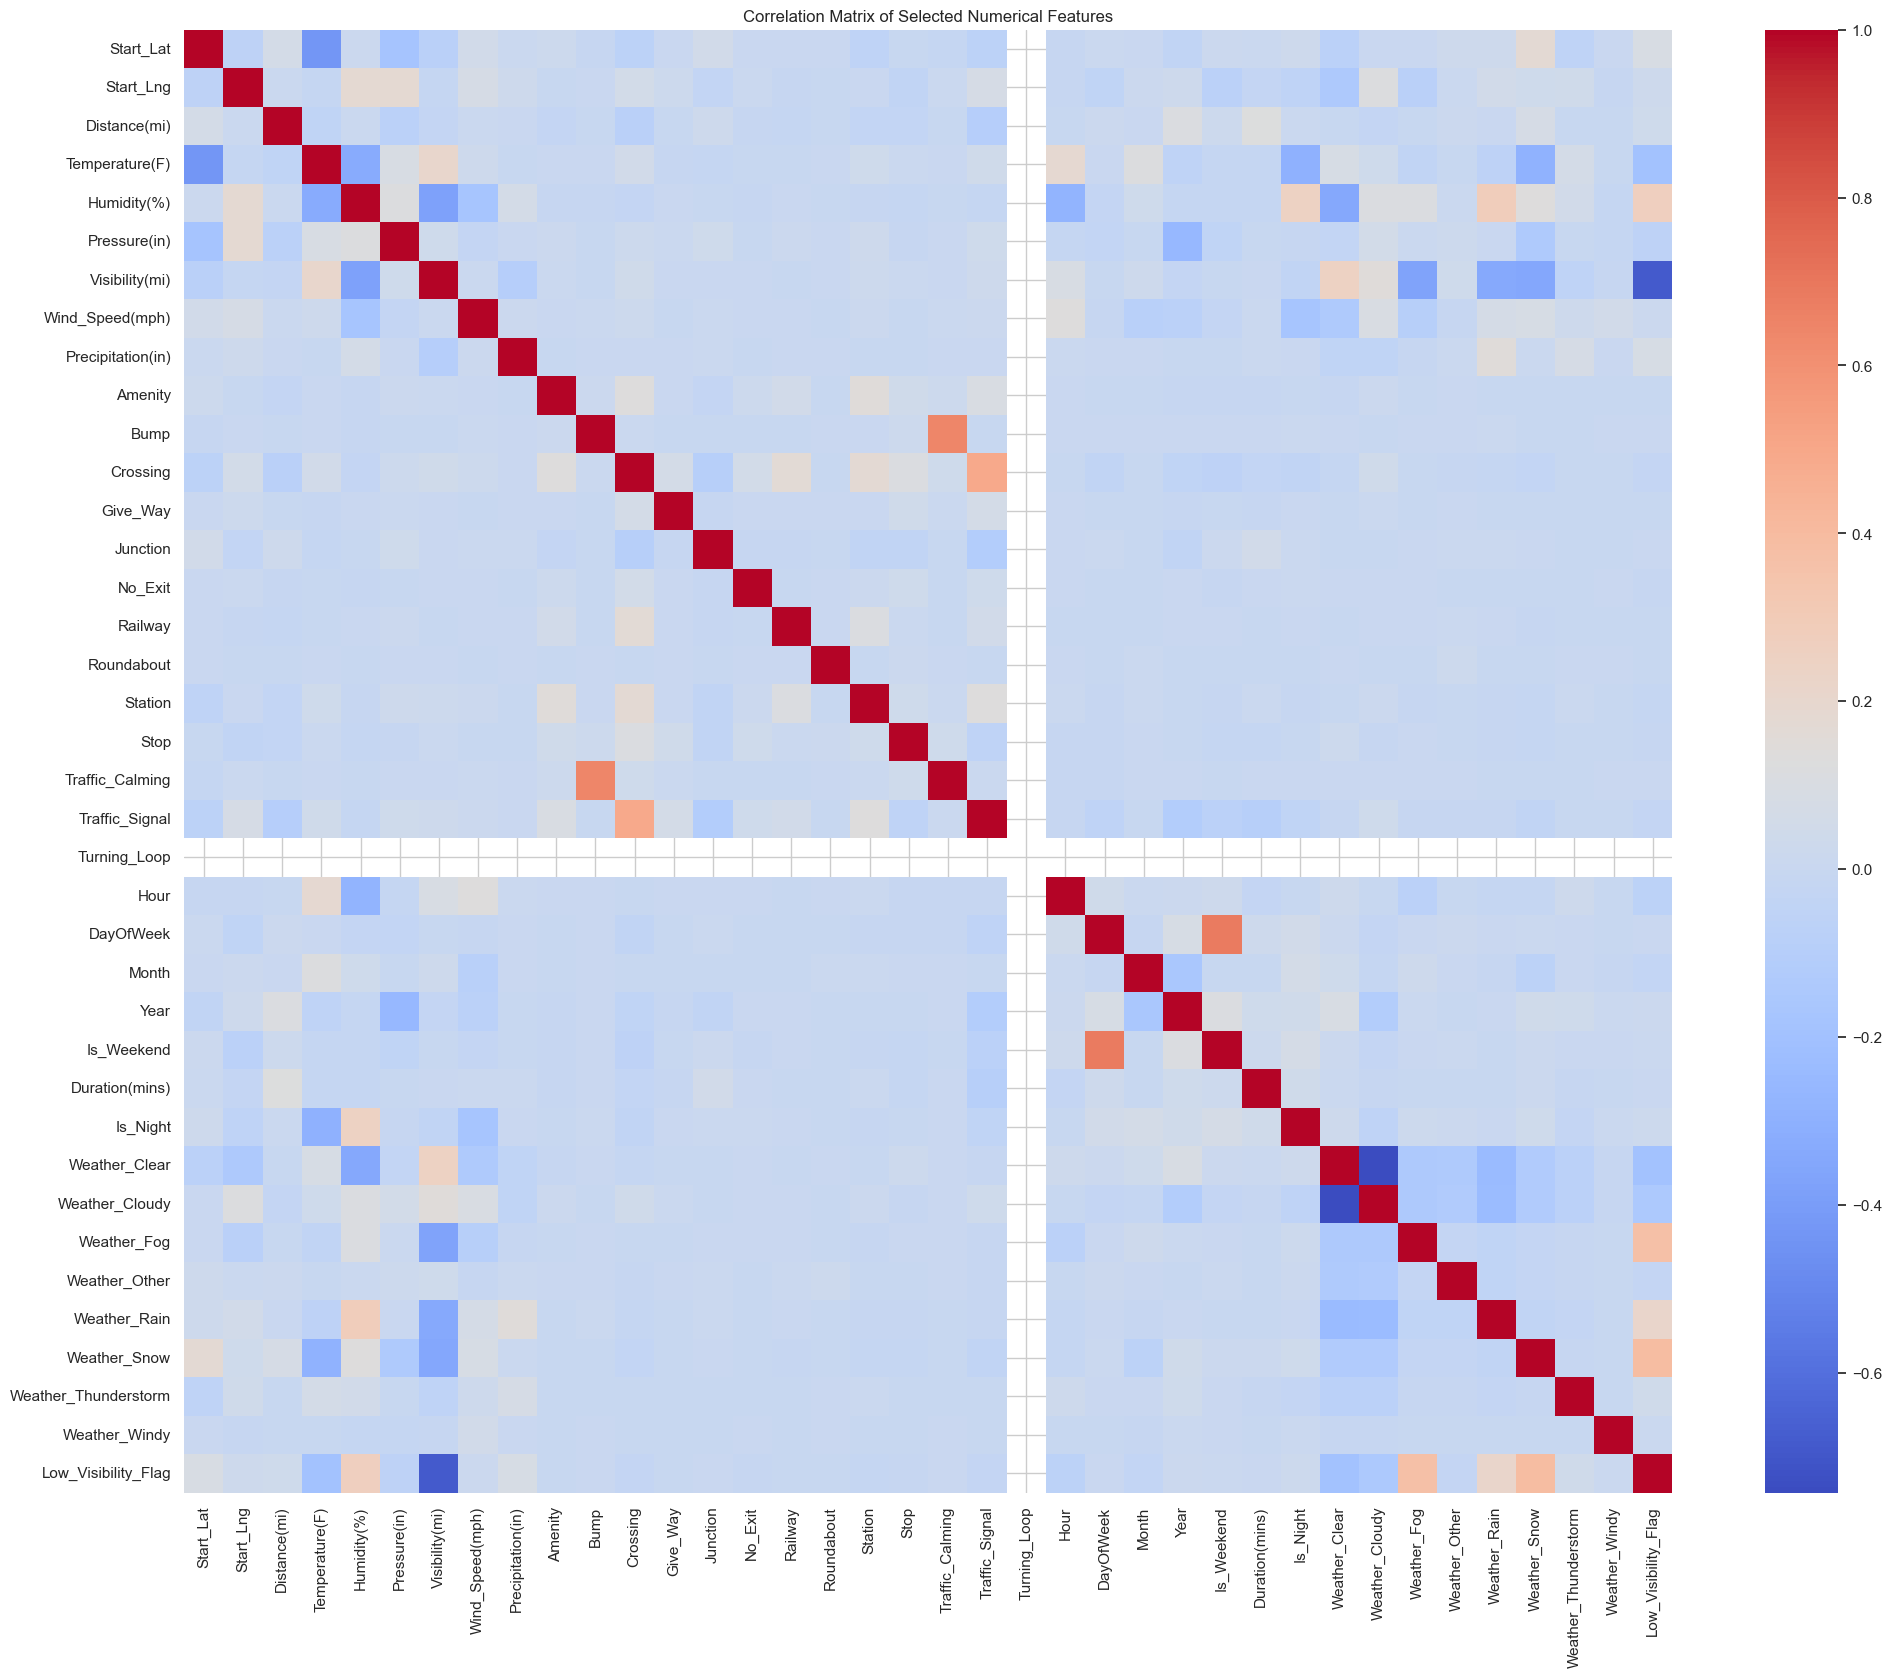


No feature pairs found with absolute correlation > 0.8.


In [72]:
# feature selection / correlation analysis

# columns to drop
columns_to_drop = [
    'ID',
    # Original Timestamp columns (replaced by engineered features)
    'Start_Time', 'End_Time', 'Weather_Timestamp',
    # Original columns replaced by engineered/encoded versions
    'Sunrise_Sunset', # -> isNight
    'Weather_Condition', # -> Weather_Simplified 
    'Weather_Simplified', # Intermediate use
    'Wind_Direction', # -> WindDir
    'State', 'Timezone', 'Source', 'County',
    'Country', # all vals are just 'US'
    'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
    'Wind_Chill(F)' #-> high corr w/ temp
]
columns_to_drop_existing = [col for col in columns_to_drop if col in df_clean.columns]
print(f"\nColumns identified for dropping: {columns_to_drop_existing}")
df_selected = df_clean.drop(columns=columns_to_drop_existing, errors='ignore')

print(f"\nShape after dropping columns: {df_selected.shape}")
print("\nRemaining columns (features + target):")
print(df_selected.columns.tolist())

# Perform correlation analysis
numerical_cols = df_selected.select_dtypes(include=np.number).columns.tolist()
numerical_features = [col for col in numerical_cols if col != 'Severity']

print(f"\nCalculating correlation matrix for {len(numerical_features)} numerical features.")
correlation_matrix = df_selected[numerical_features].corr()

# visualization
plt.figure(figsize=(24, 19))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Matrix of Selected Numerical Features")
plt.show()

# identifying high correlation pairs
threshold = 0.8
highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            corr_value = correlation_matrix.iloc[i, j]
            highly_correlated_pairs.append((col1, col2, corr_value))

if highly_correlated_pairs:
    print(f"\nFound pairs with correlation > {threshold} or < -{threshold}:")
    for pair in highly_correlated_pairs:
        print(f" - {pair[0]} and {pair[1]}: {pair[2]:.3f}")
else:
    print(f"\nNo feature pairs found with absolute correlation > {threshold}.")


df_selected.to_csv("processed_accidents.csv", index=False) #

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

df = pd.read_csv("processed_accidents.csv")
y = df['Severity']
print(f"Shape of target (y) before split: {y.shape}")
print(f"Original full dataset distribution: {Counter(y)}")
X = df.drop(columns=['Severity'])
print(f"Shape of features (X) before split: {X.shape}")

# grabbing numeric cols
numeric_feature_cols =X.select_dtypes(include=np.number).columns
X_numeric = X[numeric_feature_cols]
print(f"Using {len(numeric_feature_cols)} numeric features for SMOTE and scaling.")


# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42, stratify=y) # Added stratify
print(f"\nShape of X_train before balancing: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Original training set distribution: {Counter(y_train)}")
print(f"Original test set distribution: {Counter(y_test)}")

# balancing
print("\nApplying SMOTE to balance the training data")
smote = SMOTE(random_state=42, k_neighbors=5)
# check minority class before smote
min_class_count = Counter(y_train).most_common()[-1][1]
if min_class_count <= smote.k_neighbors:
     print(f"Warning: Smallest class count ({min_class_count}) is less than or equal to k_neighbors ({smote.k_neighbors}). Reducing k_neighbors.")
     smote.k_neighbors = max(1, min_class_count - 1)

if smote.k_neighbors < 1:
     print("Error: Cannot apply SMOTE, smallest class has only 1 sample.")
     X_train_res, y_train_res = X_train,y_train #skip balancing
else:
     X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Shape of X_train after SMOTE: {X_train_res.shape}")
print(f"Resampled training set distribution: {Counter(y_train_res)}")


# scaling
print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test) # Use transform, not fit_transform, on test data

print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")

# variables to use for model training now
# Subsequent cells should now use X_train_scaled, X_test_scaled, y_train_res, y_test
# Example (replace X_train, X_test, y_train in subsequent cells):
# X_train = X_train_scaled
# X_test = X_test_scaled
# y_train = y_train_res
# y_test = y_test (remains same)

Shape of target (y) before split: (45033,)
Original full dataset distribution: Counter({2: 34889, 3: 8503, 4: 1199, 1: 442})
Shape of features (X) before split: (45033, 56)
Using 38 numeric features for SMOTE and scaling.

Shape of X_train before balancing: (36026, 38)
Shape of X_test: (9007, 38)
Original training set distribution: Counter({2: 27911, 3: 6802, 4: 959, 1: 354})
Original test set distribution: Counter({2: 6978, 3: 1701, 4: 240, 1: 88})

Applying SMOTE to balance the training data


C:\Users\dinco\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Shape of X_train after SMOTE: (111644, 38)
Resampled training set distribution: Counter({2: 27911, 3: 27911, 4: 27911, 1: 27911})

Scaling features using StandardScaler...
Shape of X_train_scaled: (111644, 38)
Shape of X_test_scaled: (9007, 38)


In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define and train the logistic regression model
lg_clf_saga = LogisticRegression(solver="saga", penalty="l2", max_iter=1000, random_state=42).fit(X_train, y_train)
lg_clf_sag = LogisticRegression(solver="sag", penalty="l2", max_iter=1000, random_state=42).fit(X_train, y_train)

# Evaluate the model
lg_pred_saga = lg_clf_saga.predict(X_test)
lg_pred_sag = lg_clf_sag.predict(X_test)

# Print training accuracy
print(f"Logistic Regression Model (Saga) Training Accuracy: {lg_clf_saga.score(X_train, y_train)}")
print(f"Logistic Regression Model (Sag) Training Accuracy: {lg_clf_sag.score(X_train, y_train)}")

# Calculate accuracy
print(f"Logistic Regression Model (Saga) Accuracy: {accuracy_score(y_test, lg_pred_saga)}")
print(f"Logistic Regression Model (Sag) Accuracy: {accuracy_score(y_test, lg_pred_sag)}")

# Calculate precision
print(f"Logistic Regression Model (Saga) Precision: {precision_score(y_test, lg_pred_saga, average='weighted')}")
print(f"Logistic Regression Model (Sag) Precision: {precision_score(y_test, lg_pred_sag, average='weighted')}")

# Calculate recall
print(f"Logistic Regression Model (Saga) Recall: {recall_score(y_test, lg_pred_saga, average='weighted')}")
print(f"Logistic Regression Model (Sag) Recall: {recall_score(y_test, lg_pred_sag, average='weighted')}")

# Calculate F1 score
print(f"Logistic Regression Model (Saga) F1 Score: {f1_score(y_test, lg_pred_saga, average='weighted')}")
print(f"Logistic Regression Model (Sag) F1 Score: {f1_score(y_test, lg_pred_sag, average='weighted')}")


C:\Users\dinco\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Model (Saga) Training Accuracy: 0.7745794703825015
Logistic Regression Model (Sag) Training Accuracy: 0.7745794703825015
Logistic Regression Model (Saga) Accuracy: 0.7745087154435439
Logistic Regression Model (Sag) Accuracy: 0.774619740202065
Logistic Regression Model (Saga) Precision: 0.6001689968201054
Logistic Regression Model (Sag) Precision: 0.7890887668838645
Logistic Regression Model (Saga) Recall: 0.7745087154435439
Logistic Regression Model (Sag) Recall: 0.774619740202065
Logistic Regression Model (Saga) F1 Score: 0.6762837785603515
Logistic Regression Model (Sag) F1 Score: 0.6765480129544363


C:\Users\dinco\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\dinco\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dinco\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define X and y
X = df_selected.drop("Severity", axis=1)
y = df_selected["Severity"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=100, random_state=24, class_weight='balanced', max_depth=None, bootstrap=True)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest (Bagging)")
print(classification_report(y_test, y_pred_rf))

Random Forest (Bagging)
              precision    recall  f1-score   support

           1       0.67      0.11      0.19        88
           2       0.81      0.98      0.88      6978
           3       0.70      0.22      0.33      1701
           4       0.60      0.01      0.02       240

    accuracy                           0.80      9007
   macro avg       0.69      0.33      0.36      9007
weighted avg       0.78      0.80      0.75      9007



In [77]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=24)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Gradient Boosting")
print(classification_report(y_test, y_pred_gb))

Gradient Boosting
              precision    recall  f1-score   support

           1       0.62      0.27      0.38        88
           2       0.83      0.96      0.89      6978
           3       0.64      0.33      0.44      1701
           4       0.43      0.07      0.12       240

    accuracy                           0.81      9007
   macro avg       0.63      0.41      0.46      9007
weighted avg       0.78      0.81      0.78      9007



In [78]:
# Get metrics for Gradient Boosting
report_gb = classification_report(y_test, y_pred_gb, output_dict=True, zero_division=0)

# Get metrics for Random Forest
report_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)

# Store in a DataFrame using weighted avg
ensemble_results = pd.DataFrame([
    {
        'Model': 'Gradient Boosting',
        'Accuracy': report_gb['accuracy'],
        'Precision (weighted avg)': report_gb['weighted avg']['precision'],
        'Recall (weighted avg)': report_gb['weighted avg']['recall'],
        'F1-score (weighted avg)': report_gb['weighted avg']['f1-score']
    },
    {
        'Model': 'Random Forest',
        'Accuracy': report_rf['accuracy'],
        'Precision (weighted avg)': report_rf['weighted avg']['precision'],
        'Recall (weighted avg)': report_rf['weighted avg']['recall'],
        'F1-score (weighted avg)': report_rf['weighted avg']['f1-score']
    }
])

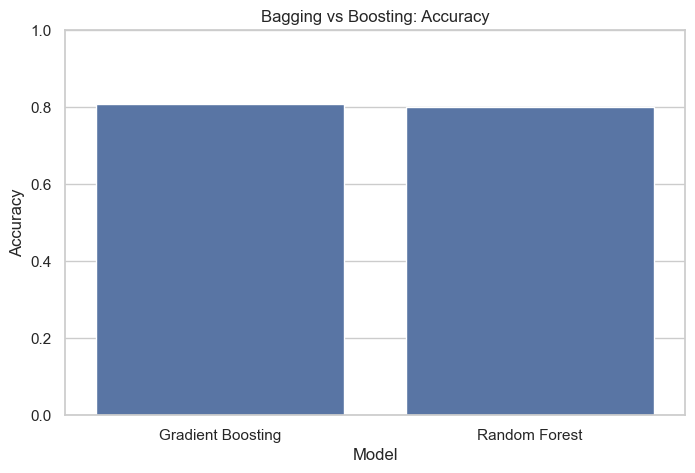

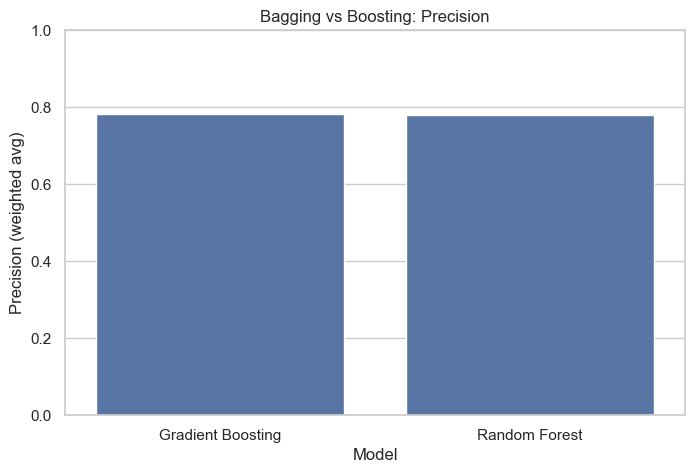

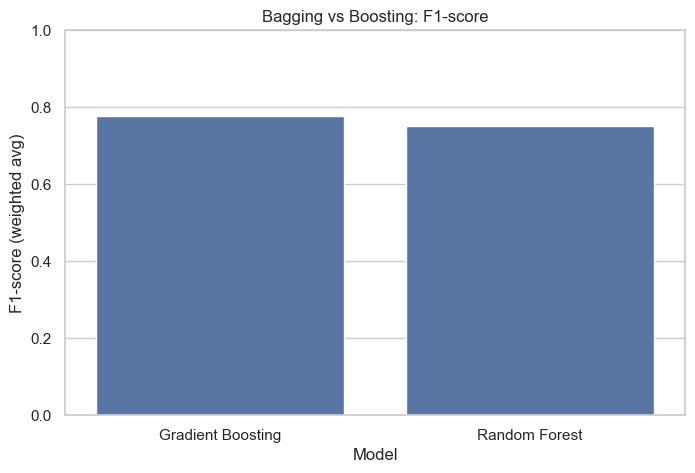

In [79]:
sns.set(style="whitegrid")

# Accuracy
plt.figure(figsize=(8, 5))
sns.barplot(data=ensemble_results, x='Model', y='Accuracy')
plt.title("Bagging vs Boosting: Accuracy")
plt.ylim(0, 1)
plt.show()

# Precision
plt.figure(figsize=(8, 5))
sns.barplot(data=ensemble_results, x='Model', y='Precision (weighted avg)')
plt.title("Bagging vs Boosting: Precision")
plt.ylim(0, 1)
plt.show()

# F1-score
plt.figure(figsize=(8, 5))
sns.barplot(data=ensemble_results, x='Model', y='F1-score (weighted avg)')
plt.title("Bagging vs Boosting: F1-score")
plt.ylim(0, 1)
plt.show()

In [80]:
from sklearn.svm import SVC

results = []
kernels = ['linear', 'rbf']
C_values = [0.1, 1, 2]

for kernel in kernels:
    for C in C_values:
        print(f"Training model with {kernel} and C = {C}")
        model = SVC(kernel=kernel, C=C, gamma='scale', class_weight='balanced')
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        print(report)
        results.append({
            'Kernel': kernel,
            'C': C,
            'Accuracy': report['accuracy'],
            'Precision (weighted avg)': report['weighted avg']['precision'],
            'Recall (weighted avg)': report['weighted avg']['recall'],
            'F1-score (weighted avg)': report['weighted avg']['f1-score']
        })

results_df = pd.DataFrame(results)

In [81]:
import sklearn
from sklearn import model_selection 
neighbors = sklearn.neighbors.KNeighborsClassifier(n_neighbors=2, p=1, n_jobs=-1) #setting N neighbors to 2 for some reason adds a lot of accuracy
neighbors.fit(X_train_scaled, y_train_res)
pred = neighbors.predict(X_test_scaled)
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, pred), "Precision:", sklearn.metrics.precision_score(y_test, pred, average= None))
print("F1 Score:", sklearn.metrics.f1_score(y_test, pred, average= None))
print("Confusion Matrix:\n", sklearn.metrics.confusion_matrix(y_test, pred))

Accuracy: 0.7152214943932497 Precision: [0.08900524 0.81828332 0.40529695 0.18691589]
F1 Score: [0.14468085 0.82910274 0.34272141 0.17621145]
Confusion Matrix:
 [[  34   43   11    0]
 [ 274 5863  703  138]
 [  64 1096  505   36]
 [  10  163   27   40]]


In [115]:
randForest = sklearn.ensemble.RandomForestClassifier(criterion="entropy", n_estimators=150, bootstrap = False) #More estimators and no bootstrap increased performance
randForest.fit(X_train_scaled, y_train_res)
pred = randForest.predict(X_test_scaled)b
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, pred))
print("Precision:", sklearn.metrics.precision_score(y_test, pred, average= None))
print("F1 Score:", sklearn.metrics.f1_score(y_test, pred, average= None))
print("Confusion Matrix:\n", sklearn.metrics.confusion_matrix(y_test, pred))

Accuracy: 0.779060730542911
Precision: [0.38202247 0.86838299 0.50595238 0.28205128]
F1 Score: [0.38418079 0.86438238 0.52690899 0.22222222]
Confusion Matrix:
 [[  34   43   11    0]
 [  32 6004  865   77]
 [  21  710  935   35]
 [   2  157   37   44]]


In [83]:
from sklearn.tree import DecisionTreeClassifier

# Define and train the decision tree classifier
dt_clf_gini = DecisionTreeClassifier(criterion="gini", max_depth=10, random_state=42).fit(X_train, y_train)
dt_clf_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=10, random_state=42).fit(X_train, y_train)
dt_clf_log = DecisionTreeClassifier(criterion="log_loss", max_depth=10, random_state=42).fit(X_train, y_train)

# Evaluate the model
dt_pred_gini = dt_clf_gini.predict(X_test)
dt_pred_entropy = dt_clf_entropy.predict(X_test)
dt_pred_log = dt_clf_log.predict(X_test)

# Print training accuracy (To ensure no overfitting is occurring)
print(f"Decision Tree Classifier (Gini) Training Accuracy: {dt_clf_gini.score(X_train, y_train)}")
print(f"Decision Tree Classifier (Entropy) Training Accuracy: {dt_clf_entropy.score(X_train, y_train)}")
print(f"Decision Tree Classifier (Log Loss) Training Accuracy: {dt_clf_log.score(X_train, y_train)}")

# Calculate accuracy
print(f"Decision Tree Classifier (Gini) Accuracy: {accuracy_score(y_test, dt_pred_gini)}")
print(f"Decision Tree Classifier (Entropy) Accuracy: {accuracy_score(y_test, dt_pred_entropy)}")
print(f"Decision Tree Classifier (Log Loss) Accuracy: {accuracy_score(y_test, dt_pred_log)}")

# Calculate precision
print(f"Decision Tree Classifier (Gini) Precision: {precision_score(y_test, dt_pred_gini, average='weighted')}")
print(f"Decision Tree Classifier (Entropy) Precision: {precision_score(y_test, dt_pred_entropy, average='weighted')}")
print(f"Decision Tree Classifier (Log Loss) Precision: {precision_score(y_test, dt_pred_log, average='weighted')}")

# Calculate recall
print(f"Decision Tree Classifier (Gini) Recall: {recall_score(y_test, dt_pred_gini, average='weighted')}")
print(f"Decision Tree Classifier (Entropy) Recall: {recall_score(y_test, dt_pred_entropy, average='weighted')}")
print(f"Decision Tree Classifier (Log Loss) Recall: {recall_score(y_test, dt_pred_log, average='weighted')}")

# Calculate F1 score
print(f"Decision Tree Classifier (Gini) F1 Score: {f1_score(y_test, dt_pred_gini, average='weighted')}")
print(f"Decision Tree Classifier (Entropy) F1 Score: {f1_score(y_test, dt_pred_entropy, average='weighted')}")
print(f"Decision Tree Classifier (Log Loss) F1 Score: {f1_score(y_test, dt_pred_log, average='weighted')}")

Decision Tree Classifier (Gini) Training Accuracy: 0.8277632820740576
Decision Tree Classifier (Entropy) Training Accuracy: 0.8202686948315105
Decision Tree Classifier (Log Loss) Training Accuracy: 0.8202686948315105
Decision Tree Classifier (Gini) Accuracy: 0.7829465970911513
Decision Tree Classifier (Entropy) Accuracy: 0.7846119684689686
Decision Tree Classifier (Log Loss) Accuracy: 0.7846119684689686
Decision Tree Classifier (Gini) Precision: 0.7610345102400853
Decision Tree Classifier (Entropy) Precision: 0.7569868260205004
Decision Tree Classifier (Log Loss) Precision: 0.7569868260205004
Decision Tree Classifier (Gini) Recall: 0.7829465970911513
Decision Tree Classifier (Entropy) Recall: 0.7846119684689686
Decision Tree Classifier (Log Loss) Recall: 0.7846119684689686
Decision Tree Classifier (Gini) F1 Score: 0.7684485426600274
Decision Tree Classifier (Entropy) F1 Score: 0.7654954837005826
Decision Tree Classifier (Log Loss) F1 Score: 0.7654954837005826


In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Load preprocessed data
df = pd.read_csv("processed_accidents.csv")
y = df["Severity"] - 1  # Convert to 0-based labels (0 to 3)
X = df.drop("Severity", axis=1)            
X = X.select_dtypes(include=[np.number])   
X = X.to_numpy()                           

y = y.values

def build_model(input_dim, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(4, activation='softmax')  # 4 classes
    ])
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

accuracies, precisions, f1s = [], [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), 1):

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = build_model(input_dim=X.shape[1], dropout_rate=0.2, optimizer='adam')

    model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_split=0.2,
        verbose=0
    )

    y_pred_probs = model.predict(X_val, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_val, y_pred, average=None, zero_division=0)

    accuracies.append(acc)
    precisions.append(prec)
    f1s.append(f1)

for i, (acc, prec, f1) in enumerate(zip(accuracies, precisions, f1s), 1):
    print(f"Fold {i}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {np.round(prec, 3)}")
    print(f"F1 Score: {np.round(f1, 3)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y[val_idx], np.argmax(model.predict(X_val), axis=1))}")
    print()

# Final average output
print("Average Metrics:")
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.round(np.mean(precisions, axis=0), 3)}")
print(f"F1 Score: {np.round(np.mean(f1s, axis=0), 3)}")



Fold 1
Accuracy: 0.7746
Precision: [0.    0.775 0.    0.   ]
F1 Score: [0.    0.873 0.    0.   ]
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
Confusion Matrix:
[[   0   59   89    0]
 [   0 8073 3557    0]
 [   0 1188 1646    0]
 [   0  304   95    0]]

Fold 2
Accuracy: 0.7680
Precision: [0.    0.775 0.183 0.   ]
F1 Score: [0.    0.869 0.022 0.   ]
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
Confusion Matrix:
[[   0   59   89    0]
 [   0 8073 3557    0]
 [   0 1188 1646    0]
 [   0  304   95    0]]

Fold 3
Accuracy: 0.6475
Precision: [0.    0.839 0.306 0.   ]
F1 Score: [0.   0.76 0.4  0.  ]
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
Confusion Matrix:
[[   0   59   89    0]
 [   0 8073 3557    0]
 [   0 1188 1646    0]
 [   0  304   95    0]]

Average Metrics:
Accuracy: 0.7300
Precision: [0.    0.796 0.163 0.   ]
F1 Score: [0.    0.834 0.141 0.   ]
